### Final Project

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix
from ISLP import load_data
from sklearn.cluster import \
     (KMeans,
      AgglomerativeClustering)
from scipy.cluster.hierarchy import \
     (dendrogram,
      cut_tree)
from ISLP.cluster import compute_linkage

np.random.seed(2)
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree, DecisionTreeRegressor

In [2]:
# Load the dataset
phishingurl_data = pd.read_csv("PhiUSIIL_Phishing_URL_Dataset.csv")
# phishingurl_data = pd.read_csv("C:\\Users\\david\\Downloads\\phiusiil+phishing+url+dataset\\PhiUSIIL_Phishing_URL_Dataset.csv")

In [3]:
# There are too many records for these scripts to run in a reasonable amount of time
# So, we take a random sample of 5000 records
url_sample = phishingurl_data.sample(5000, random_state=13)

# Set index equal to the domain field
url_sample.set_index('URL', inplace=True)

# Drop text fields: Filename, URL, TLD, Title
url_sample_data = url_sample.drop(['Domain', 'TLD', 'Title'],axis = 1)

In [4]:
feature_names = ['URLLength', 'NoOfLettersInURL', 'NoOfDegitsInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'label']
url_sample_data = url_sample[feature_names]
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(url_sample_data.drop('label',axis = 1)
                                                    , url_sample_data['label']
                                                    , test_size=0.3, random_state=13)
# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# perform PCA upon the dataset
pca = PCA(n_components=int(np.sqrt(X_train_scaled.shape[1])))
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# set the values of the dataframes to the scaled values
X_train.loc[:,:] = X_train_scaled
X_test.loc[:,:] = X_test_scaled

# X_train = X_train_pca
# X_test = X_test_pca

C:\Users\david.chen\AppData\Local\Temp\ipykernel_6764\452700995.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.54367197 -0.32340701 -0.16517998 ... -0.07024376  0.37279193
 -0.48163404]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:,:] = X_train_scaled
C:\Users\david.chen\AppData\Local\Temp\ipykernel_6764\452700995.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.92882589 -0.35301492 -0.13774692 ... -0.05163972  0.63721789
 -0.56828292]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:,:] = X_train_scaled
C:\Users\david.chen\AppData\Local\Temp\ipykernel_6764\452700995.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.75869476 -0.25982697 -0

### Linear Logistic Regression

In [5]:
# Fit linear regression model on train set
model = LogisticRegression(solver='liblinear', random_state=0)
lfit = model.fit(X_train, y_train)

# Predict on test set and calculate accuracy
lpred = lfit.predict(X_test)
acc_score = accuracy_score(lpred , y_test)

print("Accuracy: ",acc_score)

Accuracy:  0.8593333333333333


### Decision Trees

In [6]:
# fit decision tree model
tree_phishing = DecisionTreeClassifier()
tree_phishing.fit(X_train, y_train)

DecisionTreeClassifier()

In [7]:
tree_summary = export_text(tree_phishing, feature_names=X_train.columns.tolist())
print(tree_summary)

|--- NoOfOtherSpecialCharsInURL <= 0.07
|   |--- NoOfDegitsInURL <= -0.19
|   |   |--- NoOfOtherSpecialCharsInURL <= -0.28
|   |   |   |--- URLLength <= -0.31
|   |   |   |   |--- NoOfLettersInURL <= -0.33
|   |   |   |   |   |--- URLLength <= -0.34
|   |   |   |   |   |   |--- NoOfLettersInURL <= -0.37
|   |   |   |   |   |   |   |--- URLLength <= -0.37
|   |   |   |   |   |   |   |   |--- NoOfLettersInURL <= -0.42
|   |   |   |   |   |   |   |   |   |--- URLLength <= -0.40
|   |   |   |   |   |   |   |   |   |   |--- NoOfLettersInURL <= -0.46
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |   |   |   |   |   |   |--- NoOfLettersInURL >  -0.46
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- URLLength >  -0.40
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- NoOfLettersInURL >  -0.42
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |  

In [8]:
# predict on test data
tree_pred = tree_phishing.predict(X_test)

# create confusion matrix
confusion_matrix = pd.crosstab(index=tree_pred, columns=y_test, rownames=[''])
print(confusion_matrix)

label    0    1
               
0      604   12
1       21  863


In [9]:
(604+862)/(604+13+21+862)

0.9773333333333334

### SVM

In [10]:
from sklearn.svm import SVC

# grid search with SVC
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf', 'linear']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid.fit(X_train, y_train)

print(grid.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.839 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.820 total time=   0.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.847 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.817 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.831 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.836 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.823 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.841 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.821 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.839 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.814 total time=   0.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

In [11]:
# create confusion matrix
confusion_matrix = pd.crosstab(index=grid.best_estimator_.predict(X_train), columns=y_train, rownames=[''])
print(confusion_matrix)

label     0     1
                 
0      1457     1
1        15  2027


In [12]:
svm_pred = grid.best_estimator_.predict(X_test)

# create confusion matrix
confusion_matrix = pd.crosstab(index=svm_pred, columns=y_test, rownames=[''])
print(confusion_matrix)

label    0    1
               
0      612    0
1       13  875


In [13]:
(611+875) / (611+14+875)

0.9906666666666667

<BarContainer object of 7 artists>

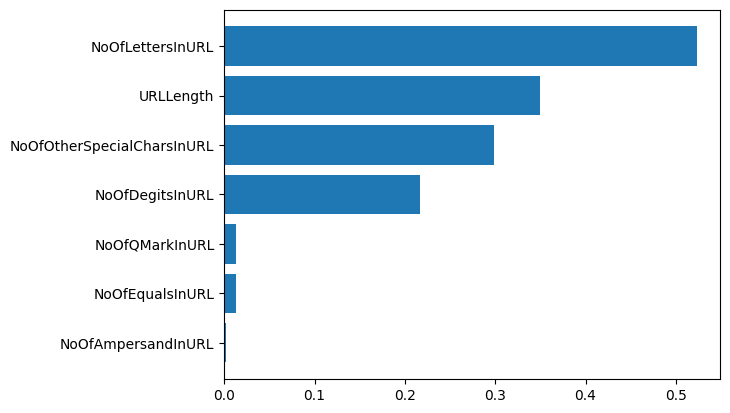

In [14]:
## getting the permutation importance with features
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(grid.best_estimator_, X_test, y_test)

sorted_idx = perm_importance.importances_mean.argsort()

plt.barh(np.array(feature_names)[sorted_idx], perm_importance.importances_mean[sorted_idx])

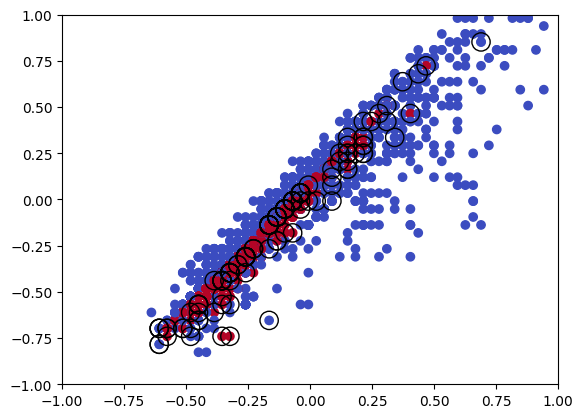

In [15]:
from ISLP.svm import plot as plot_svm

def plot_svc_decision_boundary(svm_clf, feature_idx, X, y):
    svs = svm_clf.support_vectors_
    plt.xlim(X[:, feature_idx[0]].mean() - X[:,feature_idx[0]].std(), X[:, feature_idx[0]].mean() + X[:,feature_idx[0]].std())
    plt.ylim(X[:, feature_idx[1]].mean() - X[:,feature_idx[1]].std(), X[:, feature_idx[1]].mean() + X[:,feature_idx[1]].std())
    plt.scatter(X[:, feature_idx[0]], X[:, feature_idx[1]], c=y, cmap='coolwarm')
    plt.scatter(svs[:, feature_idx[0]], svs[:, feature_idx[1]], s=len(svs), facecolors='none', edgecolors='k', linewidths=1)
    plt.show()

plot_svc_decision_boundary(grid.best_estimator_, sorted_idx[-2:], X_train.values, y_train.values)